# Table of Contents
 <p><div class="lev1 toc-item"><a href="#OSMI-Health-Survey-2016:-Model-Selection" data-toc-modified-id="OSMI-Health-Survey-2016:-Model-Selection-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>OSMI Health Survey 2016: Model Selection</a></div><div class="lev1 toc-item"><a href="#Post-Processing-Summary" data-toc-modified-id="Post-Processing-Summary-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Post-Processing Summary</a></div><div class="lev1 toc-item"><a href="#Post-Processing-EDA" data-toc-modified-id="Post-Processing-EDA-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Post-Processing EDA</a></div><div class="lev1 toc-item"><a href="#Initial-Modeling" data-toc-modified-id="Initial-Modeling-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>Initial Modeling</a></div><div class="lev2 toc-item"><a href="#Decision-Tree" data-toc-modified-id="Decision-Tree-4.1"><span class="toc-item-num">4.1&nbsp;&nbsp;</span>Decision Tree</a></div><div class="lev2 toc-item"><a href="#Logistic-Regression" data-toc-modified-id="Logistic-Regression-4.2"><span class="toc-item-num">4.2&nbsp;&nbsp;</span>Logistic Regression</a></div>

# OSMI Health Survey 2016: Model Selection

_By [Michael Rosenberg](mailto:mmrosenb@andrew.cmu.edu)._

_**Description**: Contains my model select related to the [OSMI Mental Health In Tech Survey 2016](https://osmihelp.org/research/). This notebook is written in `R`._

In [61]:
#imports
library(tree)
#constants
sigLev = 3

In [7]:
#read in the data
mainFrame = read.csv("../data/processed/procDataset.csv")

# Post-Processing Summary

After processing the dataset using [../code/cleanDataset.py](../code/cleanDataset.py), we are left with a certain set of variables:

* ```diagnosedWithMHD```: This is our main target variable. This is the variable that indicates whether an individual has been diagnosed with a mental health disorder by a medical professional.

* ```workPosString```: This is a string that contains all the job descriptions of each respondent. Each of these job descriptions are separated using the "or" character ("|").

* ```roleType```: A simplification of job descriptions to technical, non-technical, or both types of roles. This encoding is discussed partially in the [exploratory analysis](exploratoryDataAnalysis.ipynb).

* ```companySize```: A representation of the size of the company. Individuals who state that they are self-employed are indicated as "Self-employed" in this variable.

* ```age```: The age of the respondent.

* ```workCountry```: The country where a respondent works.

* ```workState```: The state where a respondent works if said respondent claims to work in the United States of America.

* ```gender```: The gender of the respondent, mapped in [../data/preprocessed/genderCountFrame.csv](../data/preprocessed/genderCountFrame.csv). Unfortunately, because of the relatively few number of individuals who did not identify on the binary, I had to aggregate all non-binary individuals into an "Other" (```O```) category. All individuals who identify as female are given the ```F``` encoding, and all individuals who identify as male are given the ```M``` encoding.

# Post-Processing EDA

Now that we have finished most of the processing, let's take a look at some of the distributions of recoded variables. This may help us to get a sense of some of the variables that we previously did not graph in our [exploratory data analysis](exploratoryDataAnalysis.ipynb).

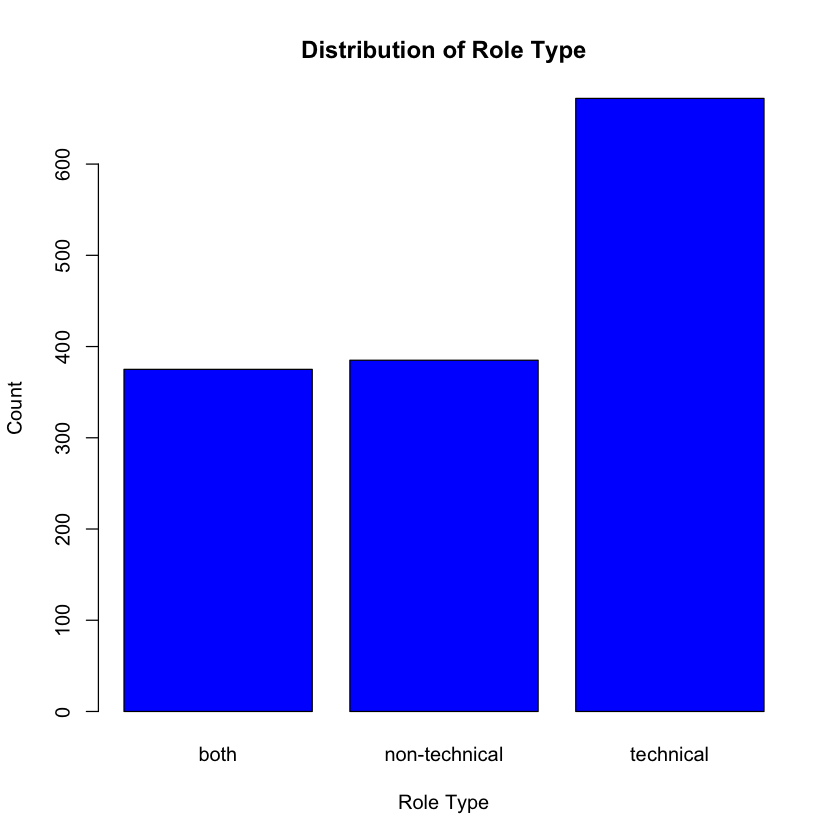

In [43]:
roleCounts = table(mainFrame$roleType)
barplot(roleCounts,main = "Distribution of Role Type",
        xlab = "Role Type",ylab = "Count",col = "Blue")

_Figure 1: Distribution of role type variable._

We see that many individuals identify as solely technical individuals. However, there are as many individuals taking on non-technical and hybrid roles as there are technical individuals. This suggest that our dataset is a reasonable mix of worker types from across the industry.

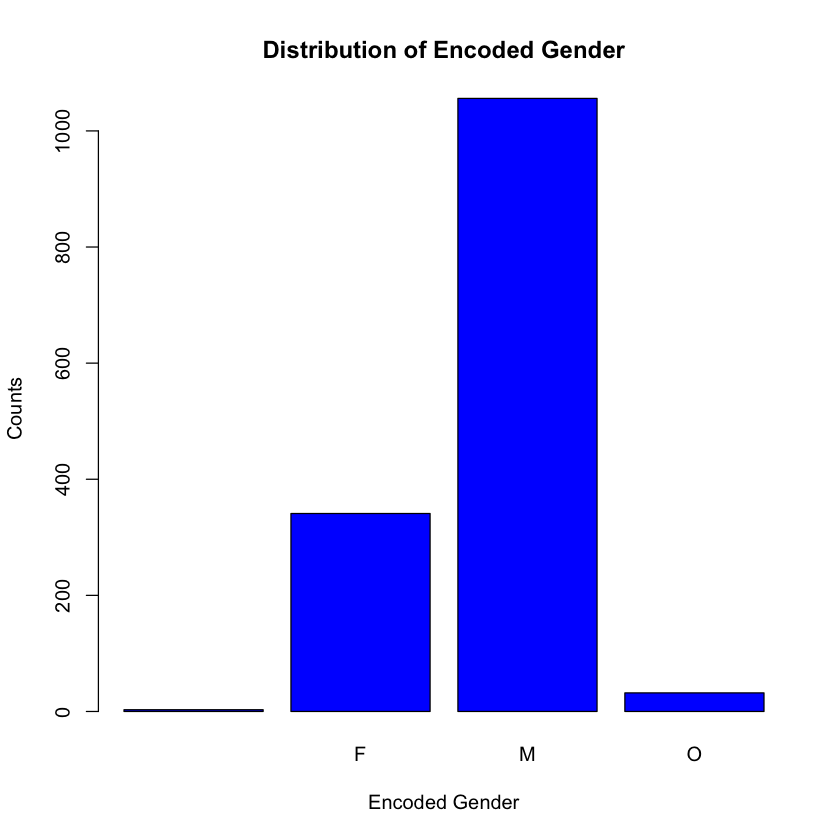

In [44]:
genderCounts = table(mainFrame$gender)
barplot(genderCounts,main = "Distribution of Encoded Gender",
        xlab = "Encoded Gender",ylab = "Counts",col = "Blue")

_Figure 2: Distribution of encoded gender._

We see that most individuals identify as male in our datset, although there is a sizable number of individuals who identify as female and a small group of individuals who identify as being non-binary. For the sake of respecting the representation of non-binary individuals in this survey, I think it is important to keep this "Other" category to ensure that they are indicated in this group.

# Initial Modeling

## Decision Tree

As discussed in the conclusion of our [exploratory data analysis](exploratoryDataAnalysis.ipynb), it is apparent that we could likely pick up on more indirect and interaction effects in our data if we consider using a decision tree. This gives us a strong graphical representation of the predictive effects presented by our data.

We will start by using all variables except for our state and country variable and we will also include a variable for representing when work is in the USA. We will call this variable ```isUSA```.

In [51]:
#make new variable
mainFrame$isUSA = 0
mainFrame[which(mainFrame$workCountry == "United States of America"),
          "isUSA"] = 1
#then fit
initialMod.tree = tree(diagnosedWithMHD ~ age + roleType + isUSA + gender
                           + companySize,data = mainFrame,split = "deviance")

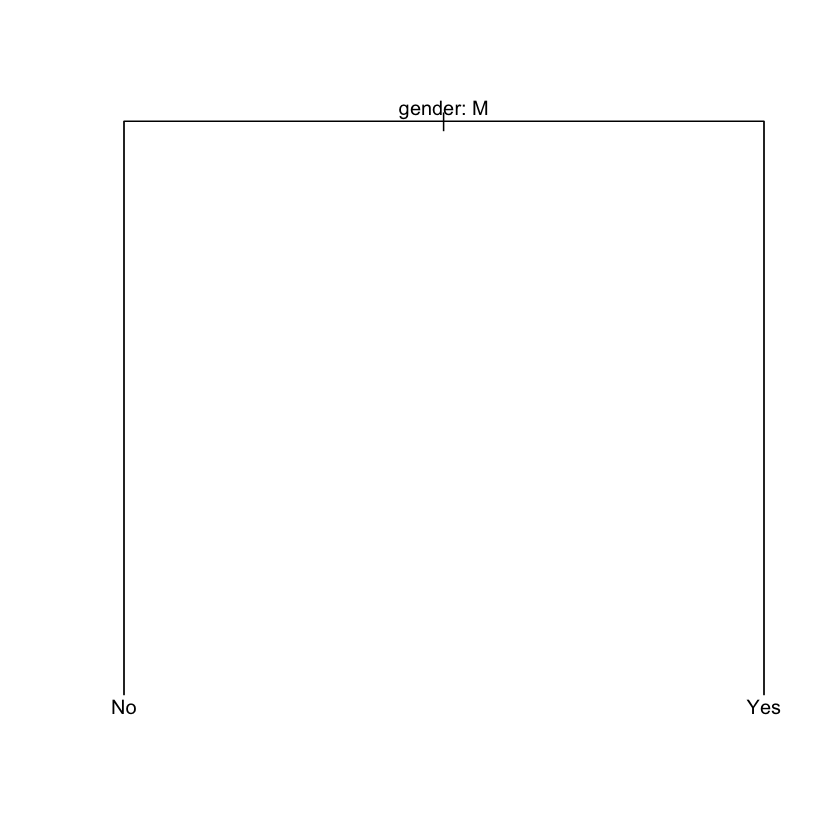

In [52]:
#then plot
plot(initialMod.tree)
text(initialMod.tree,pretty = 0)

_Figure 3: Our initial decision tree._

As expected, gender plays an essential role in informing the diagnosis rate. In particular, the effect suggests that those who identify as male are more likely to not have a mental health diagnosis than those who identify as other genders. Interestingly, all of our other covariates are so unimportant that they do not even occur in this initial model.

In [62]:
#check predictive accuracy
mainFrame$predictions = predict(initialMod.tree,type = "class")
correctFrame = mainFrame[which(
                        mainFrame$diagnosedWithMHD == mainFrame$predictions),]
propAccurate = dim(correctFrame)[1] / dim(mainFrame)[1]
#then get percent
print(paste("The proportion accurate is",signif(propAccurate,sigLev)))

[1] "The proportion accurate is 0.585"


We see that we are only getting about $58.5\%$ of our predictions right. This is so far a pretty bad model, but nonetheless a model that we might have to work with. I'm under the impression that we will have a better time diagnosing our feature engineering woes if we study the parameters of a logistic regression model.

## Logistic Regression

In [63]:
initialMod.logr = glm(diagnosedWithMHD ~ factor(age) + factor(roleType) 
                      + factor(isUSA) + factor(gender) + factor(companySize),
                      data = mainFrame,family = "binomial")

In [64]:
mainFrame$predictions = predict(initialMod.logr,type = "response")
mainFrame$predictions = ifelse(mainFrame$predictions > .5,"No",0)
correctFrame = mainFrame[which(
#                        mainFrame$diagnosedWithMHD == mainFrame$predictions),]
#propAccurate = dim(correctFrame)[1] / dim(mainFrame)[1]
#then get percent
#print(paste("The proportion accurate is",signif(propAccurate,sigLev)))

[1] 4.023537e-01 3.816475e-01 3.509695e-01 4.103919e-01 6.428693e-01
   [6] 3.542766e-01 4.906118e-01 7.322965e-01 6.638620e-01 5.252784e-01
  [11] 4.956575e-01 3.485045e-01 6.822848e-01 3.750932e-01 5.586754e-01
  [16] 2.617383e-01 6.005841e-01 2.143406e-01 5.912657e-01 5.174061e-01
  [21] 4.966818e-01 5.727184e-01 2.493641e-01 4.332514e-01 5.559343e-01
  [26] 3.277225e-01 3.368623e-01 4.272620e-01 3.631628e-01 7.147796e-01
  [31] 7.723248e-01 4.914882e-01 5.303443e-01 4.409077e-01 3.250224e-01
  [36] 4.750881e-01 4.871396e-01 3.154107e-01 3.154107e-01 3.885847e-01
  [41] 3.785616e-01 4.627200e-01 7.645531e-01 4.155434e-01 4.388705e-01
  [46] 5.480146e-01 5.701400e-01 5.333569e-01 4.103919e-01 6.585743e-01
  [51] 3.766903e-01 4.381321e-01 4.036565e-01 4.965219e-01 3.164492e-01
  [56] 7.160918e-01 4.906118e-01 4.057298e-01 6.162250e-01 4.779269e-01
  [61] 3.154922e-01 3.518375e-01 4.753687e-01 3.453159e-01 4.245454e-01
  [66] 4.442041e-01 6.762619e-01 4.680650e-01 5.131153e-01 3.518375e-01
  [71] 4.525002e-01 3.687942e-01 6.337519e-01 2.989355e-01 5.049772e-01
  [76] 2.763539e-01 1.776295e-01 5.457620e-01 6.048181e-01 5.888577e-01
  [81] 3.917639e-01 3.036854e-01 4.525002e-01 5.248814e-01 3.715223e-01
  [86] 5.333569e-01 2.632864e-01 4.102640e-01 5.252784e-01 6.360039e-01
  [91] 4.764072e-01 5.875869e-01 3.536258e-01 1.736770e-07 5.782956e-01
  [96] 5.555605e-01 6.598693e-01 6.859551e-01 4.361234e-01 7.007381e-01
 [101] 4.270454e-01 5.187002e-01 4.491389e-01 6.858895e-01 3.368623e-01
 [106] 5.345863e-01 7.173781e-01 5.722246e-01 4.327876e-01 4.106492e-01
 [111] 5.174061e-01 4.906118e-01 5.808906e-01 2.992789e-01 6.366522e-01
 [116] 7.256714e-01 5.382552e-01 5.901391e-01 7.313213e-01 4.640208e-01
 [121] 3.168176e-01 6.360039e-01 3.946951e-01 5.627063e-01 7.118711e-01
 [126] 5.602210e-01 6.073779e-01 4.232539e-01 2.509804e-01 6.650412e-01
 [131] 6.196996e-01 5.333569e-01 4.567880e-01 3.902263e-01 5.681483e-01
 [136] 5.667702e-01 4.999523e-01 5.901375e-01 6.203819e-01 5.586754e-01
 [141] 4.612365e-01 7.079246e-01 6.287805e-01 4.317921e-01 5.256971e-01
 [146] 3.817993e-01 5.248814e-01 4.457035e-01 7.335319e-01 6.052110e-01
 [151] 4.834596e-01 4.951412e-01 8.305773e-01 4.835592e-01 7.184747e-01
 [156] 4.216586e-01 5.237426e-01 4.846952e-01 3.542766e-01 3.164881e-01
 [161] 4.231650e-01 6.347373e-01 5.922649e-01 5.573239e-01 5.941823e-01
 [166] 4.217567e-01 4.559054e-01 3.777856e-01 2.762281e-01 3.687827e-01
 [171] 2.493641e-01 5.586754e-01 4.799241e-01 6.196996e-01 4.966818e-01
 [176] 5.012481e-01 5.674201e-01 8.291504e-01 3.193740e-01 4.803485e-01
 [181] 3.522495e-01 4.078817e-01 7.180660e-01 3.408408e-01 4.441023e-01
 [186] 2.669510e-01 5.224232e-01 5.430736e-01 4.908821e-01 4.827797e-01
 [191] 4.618012e-01 4.155434e-01 3.518375e-01 3.971432e-01 8.018406e-01
 [196] 4.102640e-01 4.111127e-01 4.245454e-01 4.854056e-01 4.821390e-01
 [201] 7.742941e-01 3.943148e-01 2.880605e-01 7.367889e-01 4.225141e-01
 [206] 2.695829e-01 3.313470e-01 4.906118e-01 4.306760e-01 3.932248e-01
 [211] 3.223573e-01 4.540311e-01 5.000672e-01 3.417167e-01 3.313470e-01
 [216] 3.816475e-01 3.164881e-01 2.493641e-01 2.746496e-01 2.861917e-01
 [221] 3.566217e-01 3.911281e-01 5.586754e-01 5.637143e-01 3.871836e-01
 [226] 5.709193e-01 4.742136e-01 3.480950e-01 4.906118e-01 6.203819e-01
 [231] 5.409348e-01 5.264505e-01 3.607134e-01 6.642301e-01 6.467502e-01
 [236] 4.753687e-01 2.772507e-01 3.871836e-01 4.558128e-01 3.871836e-01
 [241] 2.509804e-01 4.377497e-01 6.397375e-01 3.215418e-01 5.088791e-01
 [246] 6.585743e-01 4.733049e-01 6.528426e-01 5.131030e-01 4.416846e-01
 [251] 6.946843e-01 5.921769e-01 6.681295e-01 4.740499e-01 4.558128e-01
 [256] 3.036854e-01 4.956575e-01 4.661443e-01 6.654812e-01 4.216586e-01
 [261] 3.605016e-01 5.256971e-01 4.217567e-01 6.829052e-01 5.518677e-01
 [266] 3.741337e-01 6.895788e-01 6.725903e-01 5.488847e-01 6.858895e-01
 [271] 3.677012e-01 4.454083e-01 4.834596e-01 4.661443e-01 3.913802e-01
 [276] 4.070911e-01 4.880158e-01 5.316615e-